In [1]:
# 필요한 module import하기
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

In [2]:
# STL10 Dataset을 이용할 것이다
# Data를 다운받을 경로 설정
path2data = '/content/data'

# 만약 경로가 존재하지 않는다면 directory를 생성한다
if not os.path.exists(path2data):
    os.mkdir(path2data)

# Dataset 다운로드하기
train_ds = datasets.STL10(path2data, split='train', download=True, transform=transforms.ToTensor())
val_ds = datasets.STL10(path2data, split='test', download=True, transform=transforms.ToTensor())

print(len(train_ds))
print(len(val_ds))

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting /content/data/stl10_binary.tar.gz to /content/data
Files already downloaded and verified
5000
8000


In [3]:
# Data를 Pre-process하는 transformation 객체 정의하기
transformation = transforms.Compose([
                    transforms.ToTensor(), # 0-1값으로 normalize한 후 Tensor타입으로 정규화
                    transforms.Resize(224) # (224,224)사이즈로 정규화하기
])

train_ds.transform = transformation # train_dataset의 데이터 전처리기
val_ds.transform = transformation # validation_dataset의 데이터 전처리기

In [4]:
# 데이터로더 생성하기
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=True)

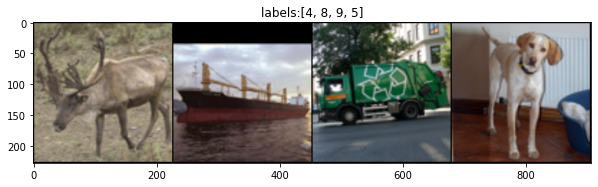

In [5]:
# 이미지를 여러 개 Display하는 함수를 정의한다
def show(img, y=None):
  # pytorch dataset의 자료형인 tensor를 numpy로 변환
  npimg = img.numpy()

  # pytorch image data는 (channel, height, width)이다. 이를 (height, width, channel)형태로 변환한다
  npimg_tr = np.transpose(npimg, (1,2,0))

  plt.imshow(npimg_tr)

  if y is not None:
    plt.title("labels:" + str(y))

grid_size=4
random_idx = np.random.randint(0, len(train_ds), grid_size)

x_grid = [train_ds[i][0] for i in random_idx] # train_ds에서 i번째 이미지
y_grid = [train_ds[i][1] for i in random_idx] # train_ds에서 i번째 이미지의 label

plt.figure(figsize=(10,10))

# 4개의 이미지를 이어붙인 grid를 만든다
x_grid = utils.make_grid(x_grid, nrow=4, padding=2)
show(x_grid, y_grid)

In [13]:
# 모델 구현
class WiderBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride):
    super().__init__()

    self.residual = nn.Sequential(
        nn.BatchNorm2d(in_channels),
        nn.ReLU(),
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Dropout(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
    )

    self.shortcut = nn.Sequential()

    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0)

  def forward(self, x):
    x_shortcut = self.shortcut(x)
    x_res = self.residual(x)
    return x_shortcut + x_res

class WRN(nn.Module):
  def __init__(self, depth=40, k=10, num_classes=10, init_weights=True):
    super().__init__()

    # 총 40 layer만큼의 모델의 구축하고 싶다
    # 그러면 conv2,3,4에 각각 몇 개의 residual block이 형성되어야 하는지 알 수 있다
    N = int((depth-4)/6)
    self.in_channels = 16

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
    self.conv2 = self._make_layer(16*k, N, 1)
    self.conv3 = self._make_layer(32*k, N, 1)
    self.conv4 = self._make_layer(64*k, N, 1)
    self.bn = nn.BatchNorm2d(64*k)
    self.relu = nn.ReLU()
    self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(64*k, num_classes)

    # weight initialization
    if init_weights:
      self._weights_initialize()

  def forward(self, x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.bn(x)
      x = self.relu(x)
      x = self.avg_pool(x)
      x = x.view(x.size(0), -1)
      x = self.fc(x)

      return x

  def _weights_initialize(self):
      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
              if m.bias is not None:
                  nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.BatchNorm2d):
              nn.init.constant_(m.weight, 1)
              nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.Linear):
              nn.init.normal_(m.weight, 0, 0.01)
              nn.init.constant_(m.bias, 0)

  def _make_layer(self, out_channels, num_block, stride):
    strides = [stride] + [1] * (num_block-1)
    layers = []

    for stride in strides:
      layers.append(WiderBlock(self.in_channels, out_channels, stride))
      self.in_channels = out_channels

    return nn.Sequential(*layers)

# 여기서 k는 widening factor로 출력층의 넓이(channel)를 조절할 수 있는 parameter이다
def WRN_40_10():
    return WRN(depth=40, k=3)

In [ ]:
# device할당 및 모델 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WRN_40_10().to(device)
summary(model, (3,224,224), device=device.type)

In [ ]:
# 본격적으로 학습을 위한 함수를 제작하자
# 하나의 batch_set의 데이터들의 손실함수가 모두 합산되어 반환되도록 정의
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import ReduceLROnPlateau
# 30회마다 Learning rate를 10분의 1로 줄여주는 Scheduler 제작
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)

# optimizer의 현재 Learning rate를 반환하는 함수 제작
def get_lr(opt):
  return opt.param_groups[0]['lr']

# model의 예측과 정답 label을 비교하여 맞춘 개수를 반환한다
def metric_batch(output, target):
  pred = output.argmax(dim=1, keepdim=True)
  corrects = pred.eq(target.view_as(pred)).sum().item()
  return corrects

# batct학습 시 손실함수 이용하여 backpropagation을 하고 나서
# 해당 batch의 총 loss값과 맞은 정답의 개수를 반환하는 함수

def loss_batch(loss_func, outputs, target, opt=None):
  # 만약 Auxiliary Classifier가 적용된 모델이 반환한 값이라면
  # Main Classifier의 반환값, Aux. classifier 1,2의 반환값이 return된다
  if len(outputs) == 3:
    output, aux1, aux2 = outputs
  
    output_loss = loss_func(output, target)
    aux1_loss = loss_func(aux1, target)
    aux2_loss = loss_func(aux2, target)

    # Aux. Classifier의 loss는 0.3을 곱하여 전체 loss에 더한다
    loss = output_loss + 0.3*(aux1_loss + aux2_loss)

    # 해당 batch_dataset에서 model이 맞춘 정답의 개수
    metric_b = metric_batch(output, target)

  else:
    loss = loss_func(outputs, target)
    metric_b = metric_batch(outputs, target)

  if opt is not None:
    opt.zero_grad()
    loss.backward()
    opt.step()

  return loss.item(), metric_b

# 해당 dataloader를 이용해 model을 1 epoch 훈련시키고
# 1epoch동안의 평균 손실함수값과 정확도를 반환하는 함수
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
  # epoch 동안의 평균 손실함수값
  # epoch 동안의 평균 Precision 저장을 위한 변수 생성
  running_loss = 0.0
  running_metric = 0.0
  len_data = len(dataset_dl.dataset)

  for xb, yb in dataset_dl:
    xb, yb = xb.to(device), yb.to(device)
    output = model(xb)

    loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

    running_loss += loss_b

    if metric_b is not None:
      running_metric += metric_b

    if sanity_check is True:
      break

  loss = running_loss  / len_data
  metric = running_metric / len_data

  return loss, metric

# configuration parameter를 params라는 인자로 전달하면
# 해당 config에 맞게 Train을 해주는 함수를 정의하였다
def train_val(model, params):
  num_epochs=params["num_epochs"]
  loss_func=params["loss_func"]
  opt=params["optimizer"]
  train_dl=params["train_dl"]
  val_dl=params["val_dl"]
  sanity_check=params["sanity_check"]
  lr_scheduler=params["lr_scheduler"]
  path2weights=params["path2weights"]

  # epoch별 평균 loss와 정확도를 저장
  loss_history = {'train':[], 'val':[]}
  metric_history = {'train':[], 'val':[]}

  # 가장 작은 손실함수값을 반환하는 모델의 가중치를 저장한다
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = float('inf')

  start_time = time.time()
  for epoch in range(num_epochs):
    current_lr = get_lr(opt)
    print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr)) 

    # 학습 모드
    model.train()
    # train_dataset 1 Epoch 훈련
    train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
    
    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    # 모델의 성능 평가모드
    model.eval()
    with torch.no_grad():
      val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

      torch.save(model.state_dict(), path2weights)
      print("Copied best model weights!")

    loss_history['val'].append(val_loss)
    metric_history['val'].append(val_metric)

    lr_scheduler.step(val_loss)
    if current_lr != get_lr(opt):
      print('Loading best model weights!')
      model.load_state_dict(best_model_wts)

    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
    print('-'*10)

  # 학습을 모두 마치기 전 가장 손실함수가 적게 반환된 가중치로 모델을 초기화한다
  model.load_state_dict(best_model_wts)

  return model, loss_history, metric_history

In [ ]:
# Training Parameter정의하기
params_train = {
    'num_epochs':30,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# 최상의 가중치를 저장할 디렉토리 생성
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [ ]:
# 30 Epoch학습 시작
model, loss_hist, metric_hist = train_val(model, params_train)

In [ ]:
# 손실함수값과 정확도 시각화하기
# Train-Val progress
num_epochs=params_train['num_epochs']

# plot loss progress
plt.title('Train_Val Loss')
plt.plot(range(1,num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1,num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot accuracy progress
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()